In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
seed=7        
set_random_seed(seed=seed)

In [3]:
df = pd.read_csv("../data/data.csv", index_col="index", converters={'valid_years_days_dict': eval})
df.head(7)

,weekday_name,month,leap_year_condition,decade,output,output_year_digit,output_year,valid_years_days_dict,valid_years_list,valid_day_list,decade4,valid_group_days_index,century_code,month_code,year_code
index,,,,,,,,,,,,,,,
0,2,1,0,180,1-1-1800,0,1800,"{0: [1, 8, 15, 22, 29], 1: [7, 14, 21, 28], 2:...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,0
1,3,1,0,180,1-1-1801,1,1801,"{0: [2, 9, 16, 23, 30], 1: [1, 8, 15, 22, 29],...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,1
2,4,1,0,180,1-1-1802,2,1802,"{0: [3, 10, 17, 24, 31], 1: [2, 9, 16, 23, 30]...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,2
3,5,1,0,180,1-1-1803,3,1803,"{0: [4, 11, 18, 25], 1: [3, 10, 17, 24, 31], 2...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,3
4,6,1,1,180,1-1-1804,4,1804,"{4: [1, 8, 15, 22, 29], 8: [3, 10, 17, 24, 31]}","[4, 8, 4, 4, 4, 4, 4, 4]","[1, 8, 15, 22, 29]",0,7,2,0,5
5,1,1,0,180,1-1-1805,5,1805,"{0: [7, 14, 21, 28], 1: [6, 13, 20, 27], 2: [5...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,6
6,2,1,0,180,1-1-1806,6,1806,"{0: [1, 8, 15, 22, 29], 1: [7, 14, 21, 28], 2:...","[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,7,2,0,0


- given the columns features we can't by any means diffrentiate between the day 1 or day 8 or 15 or 22 or 28 because they may share the same exact feature columns values and they all still correct, and the model see them all as the same thing, so i make lists for the identical days from the feature columns point of view, and instead of training the model to select certain day, i trained the model to select index of days-list which i named "groups", as example if the output of the model is 0 then it equivalent to selecting any day from these days [1, 8, 15, 22], if the output is 1 so it's equivalent to selecting any number from [2, 9, 16, 23] and so on(see groups_dict dictionary)

In [4]:
# list of all possibole (10) output lists, the output must be one of theses lists
groups = [[1, 8, 15, 22], 
         [2, 9, 16, 23], 
         [3, 10, 17, 24], 
         [4, 11, 18, 25], 
         [5, 12, 19, 26], 
         [6, 13, 20, 27], 
         [7, 14, 21, 28],
         [1, 8, 15, 22, 29], 
         [2, 9, 16, 23, 30], 
         [3, 10, 17, 24, 31]]
groups_dict = dict(enumerate(groups))
groups_dict

{0: [1, 8, 15, 22],
 1: [2, 9, 16, 23],
 2: [3, 10, 17, 24],
 3: [4, 11, 18, 25],
 4: [5, 12, 19, 26],
 5: [6, 13, 20, 27],
 6: [7, 14, 21, 28],
 7: [1, 8, 15, 22, 29],
 8: [2, 9, 16, 23, 30],
 9: [3, 10, 17, 24, 31]}

**B- training for getting the day**

In [5]:
df[["weekday_name", "month", "output_year", "leap_year_condition", "valid_group_days_index"]].head()

,weekday_name,month,output_year,leap_year_condition,valid_group_days_index
index,,,,,
0,2,1,1800,0,7
1,3,1,1801,0,7
2,4,1,1802,0,7
3,5,1,1803,0,7
4,6,1,1804,1,7


In [6]:
# first try
# df["century"] = df.output_year//100
# df["century_decade"] = (df.output_year//10)-(df["century"]*10)
# df["decade_year"] = df.output_year-(df.output_year//10)*10
# df["century"] = df.century-df.century.min()
# x_day = df[["weekday_name", "month", "century", "century_decade", "decade_year", "leap_year_condition", "valid_group_days_index"]]
# df["century"].unique(), df["decade_year"].unique(), df["century_decade"].unique()

In [7]:
# second try
# df["century"] = df.output_year//100
# df["century_year"] = df.output_year-df["century"]*100
# df["century_year"] = df["century_year"]#/10
# df["century"] = df.century-df.century.min()
# x_day = df[["weekday_name", "month", "century", "century_year", "leap_year_condition", "valid_group_days_index"]]
# df["century"].unique(), df["century_year"].unique()

In [8]:
x_day = df[["weekday_name", "month", "month_code", "century_code", "year_code", "leap_year_condition", "valid_group_days_index"]]
x_day.head()

,weekday_name,month,month_code,century_code,year_code,leap_year_condition,valid_group_days_index
index,,,,,,,
0,2,1,0,2,0,0,7
1,3,1,0,2,1,0,7
2,4,1,0,2,2,0,7
3,5,1,0,2,3,0,7
4,6,1,0,2,5,1,7


In [9]:
y_day = x_day.pop("valid_group_days_index") # from 0 to 9

7    22540
8    22055
3    19248
4    19248
5    19248
6    19248
9    14035
2     8020
1     1604
0     1216
Name: valid_group_days_index, dtype: int64


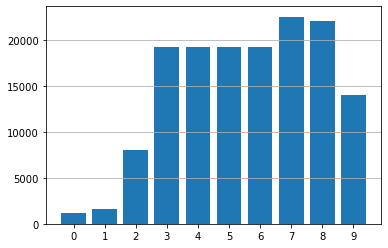

In [10]:
pprint(df.valid_group_days_index.value_counts())
plt.bar(df.valid_group_days_index.value_counts().index, df.valid_group_days_index.value_counts())
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

**the output column is imbalanced**

In [11]:
# import the same data indices for training and test which used in train_year notebook which saved in csv files
train_indices = pd.read_csv("../data/train_indices.csv", index_col="index").index
test_indices = pd.read_csv("../data/test_indices.csv", index_col="index").index

xtrain_day = x_day.iloc[train_indices, :]
xtest_day = x_day.iloc[test_indices, :]
ytrain_day = y_day.iloc[train_indices]
ytest_day = y_day.iloc[test_indices]

# # so i will not need to use this train_test_split function here
# xtrain_day, xtest_day, ytrain_day, ytest_day = train_test_split(x_day, y_day, 
#                                                                 test_size=0.19, 
#                                                                 shuffle=True, 
#                                                                 random_state=seed, 
#                                                                 stratify=df.valid_group_days_index)

# make oversampling to fix the imbalanced classes
ros = RandomOverSampler(random_state=seed)
x_day_train_sampld, y_day_train_sampld = ros.fit_resample(xtrain_day, ytrain_day)

In [12]:
print(f"ytrain_day = {len(ytrain_day)//1000}k,\nytest_day = {len(ytest_day)//1000}k, \ny_day_train_sampld = {len(x_day_train_sampld)//1000}k")

ytrain_day = 118k,
ytest_day = 27k, 
y_day_train_sampld = 182k


6    18257
9    18257
5    18257
2    18257
4    18257
8    18257
7    18257
3    18257
1    18257
0    18257
Name: valid_group_days_index, dtype: int64


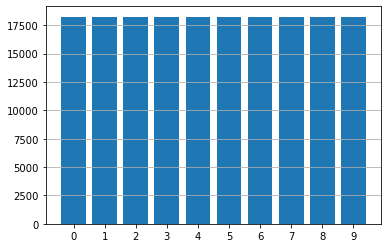

In [13]:
#**after oversampling**
pprint(y_day_train_sampld.value_counts())
plt.bar(y_day_train_sampld.value_counts().index, y_day_train_sampld.value_counts())
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

In [14]:
class CollectedData(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x.values.astype(np.float32))
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]
        
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    def __len__(self):
        return self.n_smpl    
    
train_set_day = CollectedData(x_day_train_sampld, y_day_train_sampld)
test_set_day = CollectedData(xtest_day, ytest_day)    

In [15]:
## random_split() isn't suitable here, so that i used train_test_split function
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels_day = torch.tensor(ytrain_day.values.astype(np.float32)) 
# test_labels_day = torch.tensor(ytest_day.values.astype(np.float32)) 
# train_input_day = torch.tensor(xtrain_day.values.astype(np.float32)) 
# test_input_day = torch.tensor(xtest_day.values.astype(np.float32)) 

# train_set_day = TensorDataset(train_input_day, train_labels_day)
# test_set_day = TensorDataset(test_input_day, test_labels_day)


In [16]:
batch_size = 128

train_loader_day = DataLoader(dataset=train_set_day, shuffle=True, batch_size=batch_size)
test_loader_day = DataLoader(dataset=test_set_day, batch_size=batch_size) 

In [17]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader=train_loader_day):
    model.eval()
    
    num_correct, num_samples = 0, 0

    for data, labels in data_loader:
        
        # transfering data to cuda
        data = data.to(device=device)
        labels = labels.to(device=device)
                
        preds = model(data)
        num_correct += sum(list(preds.argmax(dim=1)==labels))
        num_samples += len(labels)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy  

In [18]:
class network(nn.Module):
    def __init__(self, in_features=5, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 24)
        self.fc2 = nn.Linear(24, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 14)
        self.fc5 = nn.Linear(14, out_features) 
        self.initialize_weights()
        
        
    def forward(self, inpt):
        out = F.relu(self.fc1(inpt))
        out = F.relu(self.fc2(out))
        out = F.leaky_relu(self.fc3(out))
        out = F.leaky_relu(self.fc4(out))
        out = ((self.fc5(out)))
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [19]:
# initializing the model
model = network(in_features=6, out_features=10).to(device)
lr = 0.001
# loss and optimizer initializing
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=53, verbose=True)
model

network(
  (fc1): Linear(in_features=6, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=10, bias=True)
)

In [20]:
num_epochs = 155
def train_model(num_epochs, data_loader=train_loader_day):
    num_batches = len(data_loader)
    print(f"""batch_size = {batch_size} \n starting learning rate = {lr} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")
   
    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels) in progress: 

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader_day)
        test_acc = calculate_accuracy(model, data_loader=test_loader_day)

        print(f"after {1+epoch} epoch, train_accuracy = {(train_acc*100):.2f}%, test_accuracy = {(test_acc*100):.2f}%,\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts")
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
        schedular.step(test_acc)
        if test_acc==1 and train_acc==1:
            return result_train_acc, result_test_acc
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader_day)


batch_size = 128 
 starting learning rate = 0.001 
 number of epochs = 155    
 number of batches = 1427 
 model = network(
  (fc1): Linear(in_features=6, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=10, bias=True)
), 
 criterion=CrossEntropyLoss(), 
 optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


epoch [1/155], loss=1.6194: 100%|██████████████████████████████████████████████████| 1427/1427 [00:20<00:00, 68.81it/s]


after 1 epoch, train_accuracy = 30.68%, test_accuracy = 17.61%,        time_elapsed = 0.5 minuts


epoch [2/155], loss=1.7331: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 92.51it/s]


after 2 epoch, train_accuracy = 36.11%, test_accuracy = 21.85%,        time_elapsed = 0.4 minuts


epoch [3/155], loss=1.3980: 100%|██████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 88.19it/s]


after 3 epoch, train_accuracy = 42.46%, test_accuracy = 24.37%,        time_elapsed = 0.4 minuts


epoch [4/155], loss=1.2146: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 92.31it/s]


after 4 epoch, train_accuracy = 49.23%, test_accuracy = 32.90%,        time_elapsed = 0.4 minuts


epoch [5/155], loss=0.9922: 100%|██████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 97.61it/s]


after 5 epoch, train_accuracy = 59.57%, test_accuracy = 47.37%,        time_elapsed = 0.4 minuts


epoch [6/155], loss=1.1797: 100%|██████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 96.46it/s]


after 6 epoch, train_accuracy = 65.34%, test_accuracy = 54.65%,        time_elapsed = 0.3 minuts


epoch [7/155], loss=0.9327: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 105.88it/s]


after 7 epoch, train_accuracy = 68.24%, test_accuracy = 59.37%,        time_elapsed = 0.3 minuts


epoch [8/155], loss=0.7117: 100%|██████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 99.85it/s]


after 8 epoch, train_accuracy = 74.79%, test_accuracy = 69.45%,        time_elapsed = 0.4 minuts


epoch [9/155], loss=0.6599: 100%|██████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 96.35it/s]


after 9 epoch, train_accuracy = 77.75%, test_accuracy = 71.84%,        time_elapsed = 0.3 minuts


epoch [10/155], loss=0.4990: 100%|████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 103.99it/s]


after 10 epoch, train_accuracy = 80.44%, test_accuracy = 76.14%,        time_elapsed = 0.4 minuts


epoch [11/155], loss=0.7053: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.38it/s]


after 11 epoch, train_accuracy = 85.61%, test_accuracy = 81.87%,        time_elapsed = 0.4 minuts


epoch [12/155], loss=0.5296: 100%|█████████████████████████████████████████████████| 1427/1427 [00:19<00:00, 74.55it/s]


after 12 epoch, train_accuracy = 88.02%, test_accuracy = 85.31%,        time_elapsed = 0.5 minuts


epoch [13/155], loss=0.2215: 100%|█████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 93.27it/s]


after 13 epoch, train_accuracy = 88.16%, test_accuracy = 85.13%,        time_elapsed = 0.4 minuts


epoch [14/155], loss=0.2361: 100%|████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 100.84it/s]


after 14 epoch, train_accuracy = 91.66%, test_accuracy = 89.74%,        time_elapsed = 0.4 minuts


epoch [15/155], loss=0.3595: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 96.11it/s]


after 15 epoch, train_accuracy = 93.12%, test_accuracy = 91.79%,        time_elapsed = 0.4 minuts


epoch [16/155], loss=0.1789: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 97.85it/s]


after 16 epoch, train_accuracy = 92.92%, test_accuracy = 91.34%,        time_elapsed = 0.4 minuts


epoch [17/155], loss=0.5772: 100%|█████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 95.00it/s]


after 17 epoch, train_accuracy = 94.34%, test_accuracy = 93.34%,        time_elapsed = 0.4 minuts


epoch [18/155], loss=0.0680: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 96.93it/s]


after 18 epoch, train_accuracy = 96.15%, test_accuracy = 95.17%,        time_elapsed = 0.4 minuts


epoch [19/155], loss=0.1695: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 96.92it/s]


after 19 epoch, train_accuracy = 95.78%, test_accuracy = 94.42%,        time_elapsed = 0.4 minuts


epoch [20/155], loss=0.0758: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.09it/s]


after 20 epoch, train_accuracy = 96.91%, test_accuracy = 96.13%,        time_elapsed = 0.5 minuts


epoch [21/155], loss=0.1665: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.09it/s]


after 21 epoch, train_accuracy = 97.86%, test_accuracy = 97.13%,        time_elapsed = 0.5 minuts


epoch [22/155], loss=0.2329: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.04it/s]


after 22 epoch, train_accuracy = 98.04%, test_accuracy = 97.23%,        time_elapsed = 0.5 minuts


epoch [23/155], loss=0.0686: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 82.60it/s]


after 23 epoch, train_accuracy = 98.66%, test_accuracy = 98.02%,        time_elapsed = 0.5 minuts


epoch [24/155], loss=0.0565: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 82.91it/s]


after 24 epoch, train_accuracy = 98.81%, test_accuracy = 98.22%,        time_elapsed = 0.5 minuts


epoch [25/155], loss=0.0652: 100%|█████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 89.52it/s]


after 25 epoch, train_accuracy = 98.54%, test_accuracy = 97.83%,        time_elapsed = 0.4 minuts


epoch [26/155], loss=0.0228: 100%|█████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 95.02it/s]


after 26 epoch, train_accuracy = 98.43%, test_accuracy = 97.73%,        time_elapsed = 0.4 minuts


epoch [27/155], loss=0.0170: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 99.24it/s]


after 27 epoch, train_accuracy = 98.66%, test_accuracy = 98.25%,        time_elapsed = 0.4 minuts


epoch [28/155], loss=0.0389: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 96.05it/s]


after 28 epoch, train_accuracy = 99.25%, test_accuracy = 98.87%,        time_elapsed = 0.4 minuts


epoch [29/155], loss=0.0322: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 97.14it/s]


after 29 epoch, train_accuracy = 98.60%, test_accuracy = 98.25%,        time_elapsed = 0.4 minuts


epoch [30/155], loss=0.0714: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 81.84it/s]


after 30 epoch, train_accuracy = 99.38%, test_accuracy = 99.15%,        time_elapsed = 0.5 minuts


epoch [31/155], loss=0.0195: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.13it/s]


after 31 epoch, train_accuracy = 98.54%, test_accuracy = 98.48%,        time_elapsed = 0.5 minuts


epoch [32/155], loss=0.0377: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.89it/s]


after 32 epoch, train_accuracy = 99.27%, test_accuracy = 99.08%,        time_elapsed = 0.5 minuts


epoch [33/155], loss=0.0180: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.85it/s]


after 33 epoch, train_accuracy = 99.33%, test_accuracy = 98.95%,        time_elapsed = 0.5 minuts


epoch [34/155], loss=0.0205: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.49it/s]


after 34 epoch, train_accuracy = 99.49%, test_accuracy = 99.20%,        time_elapsed = 0.5 minuts


epoch [35/155], loss=0.0164: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.28it/s]


after 35 epoch, train_accuracy = 98.30%, test_accuracy = 97.89%,        time_elapsed = 0.5 minuts


epoch [36/155], loss=0.0117: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.07it/s]


after 36 epoch, train_accuracy = 99.66%, test_accuracy = 99.44%,        time_elapsed = 0.4 minuts


epoch [37/155], loss=0.0035: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.81it/s]


after 37 epoch, train_accuracy = 99.75%, test_accuracy = 99.67%,        time_elapsed = 0.5 minuts


epoch [38/155], loss=0.0447: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.06it/s]


after 38 epoch, train_accuracy = 99.77%, test_accuracy = 99.68%,        time_elapsed = 0.5 minuts


epoch [39/155], loss=0.0180: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 96.81it/s]


after 39 epoch, train_accuracy = 99.45%, test_accuracy = 99.15%,        time_elapsed = 0.4 minuts


epoch [40/155], loss=0.0578: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 97.79it/s]


after 40 epoch, train_accuracy = 98.70%, test_accuracy = 98.17%,        time_elapsed = 0.4 minuts


epoch [41/155], loss=0.2444: 100%|████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 100.34it/s]


after 41 epoch, train_accuracy = 97.47%, test_accuracy = 97.81%,        time_elapsed = 0.4 minuts


epoch [42/155], loss=0.0160: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 98.03it/s]


after 42 epoch, train_accuracy = 99.85%, test_accuracy = 99.81%,        time_elapsed = 0.4 minuts


epoch [43/155], loss=0.0073: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.99it/s]


after 43 epoch, train_accuracy = 99.34%, test_accuracy = 99.16%,        time_elapsed = 0.5 minuts


epoch [44/155], loss=0.0122: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.20it/s]


after 44 epoch, train_accuracy = 99.80%, test_accuracy = 99.74%,        time_elapsed = 0.5 minuts


epoch [45/155], loss=0.0032: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.34it/s]


after 45 epoch, train_accuracy = 99.75%, test_accuracy = 99.70%,        time_elapsed = 0.5 minuts


epoch [46/155], loss=0.0049: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.61it/s]


after 46 epoch, train_accuracy = 99.69%, test_accuracy = 99.58%,        time_elapsed = 0.5 minuts


epoch [47/155], loss=0.0033: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.43it/s]


after 47 epoch, train_accuracy = 99.79%, test_accuracy = 99.75%,        time_elapsed = 0.5 minuts


epoch [48/155], loss=0.0179: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.27it/s]


after 48 epoch, train_accuracy = 99.84%, test_accuracy = 99.80%,        time_elapsed = 0.5 minuts


epoch [49/155], loss=0.0057: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.17it/s]


after 49 epoch, train_accuracy = 99.84%, test_accuracy = 99.81%,        time_elapsed = 0.5 minuts


epoch [50/155], loss=0.0023: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.46it/s]


after 50 epoch, train_accuracy = 99.95%, test_accuracy = 99.95%,        time_elapsed = 0.5 minuts


epoch [51/155], loss=0.0142: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.04it/s]


after 51 epoch, train_accuracy = 99.86%, test_accuracy = 99.82%,        time_elapsed = 0.5 minuts


epoch [52/155], loss=0.0027: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.21it/s]


after 52 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.5 minuts


epoch [53/155], loss=0.0017: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.08it/s]


after 53 epoch, train_accuracy = 99.86%, test_accuracy = 99.82%,        time_elapsed = 0.5 minuts


epoch [54/155], loss=0.0013: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 80.30it/s]


after 54 epoch, train_accuracy = 99.86%, test_accuracy = 99.82%,        time_elapsed = 0.5 minuts


epoch [55/155], loss=0.0010: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.56it/s]


after 55 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.5 minuts
Epoch 00055: reducing learning rate of group 0 to 1.0000e-04.


epoch [56/155], loss=0.0010: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 85.57it/s]


after 56 epoch, train_accuracy = 99.86%, test_accuracy = 99.82%,        time_elapsed = 0.4 minuts


epoch [57/155], loss=0.0015: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 97.65it/s]


after 57 epoch, train_accuracy = 99.96%, test_accuracy = 99.95%,        time_elapsed = 0.4 minuts


epoch [58/155], loss=0.0097: 100%|████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 100.73it/s]


after 58 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.4 minuts


epoch [59/155], loss=0.0037: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 98.15it/s]


after 59 epoch, train_accuracy = 99.96%, test_accuracy = 99.97%,        time_elapsed = 0.4 minuts


epoch [60/155], loss=0.0040: 100%|█████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 99.16it/s]


after 60 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.4 minuts


epoch [61/155], loss=0.0020: 100%|█████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.85it/s]


after 61 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.5 minuts


epoch [62/155], loss=0.0018: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.34it/s]


after 62 epoch, train_accuracy = 99.99%, test_accuracy = 100.00%,        time_elapsed = 0.5 minuts


epoch [63/155], loss=0.0008: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.47it/s]


after 63 epoch, train_accuracy = 99.96%, test_accuracy = 99.97%,        time_elapsed = 0.5 minuts


epoch [64/155], loss=0.0005: 100%|█████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.35it/s]


after 64 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.5 minuts


In [21]:
print(f"maximun training accuracy={(max(result_train_acc)*100):.2f}%\nmaximun test accuracy={(max(result_test_acc))*100:.2f}%\nafter only {len(result_train_acc)} epochs")

maximun training accuracy=100.00%
maximun test accuracy=100.00%
after only 64 epochs


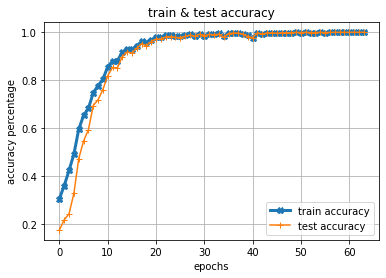

In [22]:
train_line_val = np.array([val.cpu() for val in result_train_acc]) # just replace val with val.cpu() if output is cuda
test_line_val = np.array([val.cpu() for val in result_test_acc]) # just replace val with val.cpu() if output is cuda

train_line, = plt.plot((range(len(train_line_val))), train_line_val, label="train accuracy", marker="x", linewidth=3)
test_line, = plt.plot((range(len(test_line_val))), test_line_val, label="test accuracy", marker="+", linewidth=1.5)
plt.legend(loc="best", handles=[train_line, test_line])
plt.title("train & test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.grid()
plt.show()

In [23]:
# torch.save(model, "../data/day_model_saved")
# model = torch.load("../data/day_model_saved")

In [24]:
# in this step i need to predict the day for the year i predict in the previous model(training_year notebook), 
# so i will import the predicted_year column that i generate using the training_year notebook to use here
dp = pd.read_csv("../data/year_predictions.csv", index_col="index").predicted_year

# i also need to recalculate the year_code column for the test data as it depend on the year
year_code = dp%100
year_code = ((year_code//4)+year_code)%7

In [25]:
d_test = xtest_day.copy(deep=True)
d_test["year_code"] = year_code
dt = d_test.copy(deep=True)
d_test = torch.tensor(d_test.values.astype(np.float32))
preds = model(d_test.to(device=device)).argmax(dim=1).cpu()
dt["predicted_year"] = dp
dt["predicted_days_group_index"] = preds

# i need to recalculate this value as it depend on the year which is may differ from the year in xtest
dt["correct_days_group_index"] = [groups.index(dic[key]) for dic, key in zip(df.loc[dt.index, "valid_years_days_dict"], (dt["predicted_year"]%10))]

dt["predicted_day"] = [np.random.choice(groups_dict[i]) for i in dt["predicted_days_group_index"]]
dt.head()

,weekday_name,month,month_code,century_code,year_code,leap_year_condition,predicted_year,predicted_days_group_index,correct_days_group_index,predicted_day
index,,,,,,,,,,
19729,3,2,3,2,0,1,1884,6,6,28
18483,5,11,3,2,6,0,1833,8,8,30
103614,6,7,6,0,2,1,1952,5,5,13
8841,1,11,3,2,2,0,1813,8,8,23
97054,5,3,3,2,1,1,1812,6,6,28


In [26]:
# predicted_days_group_index column is identical to correct_days_group_index that's means all predicted 
# days group is equals the correct days group
print(f"number of wrong predictions = {(dt.predicted_days_group_index!=dt.correct_days_group_index).sum()}")

number of wrong predictions = 0


In [27]:
# days_tensor = torch.tensor((xtest_day[["weekday_name", "month", "month_code", "century_code", "year_code", "leap_year_condition"]].values.astype(np.float32)))
# preds = model(days_tensor.to(device=device)).argmax(dim=1).cpu()
# preds

In [28]:
# dt.to_csv("../data/day_predictions.csv", header=True, index=True)

In [32]:
# dt[["weekday_name", "month", "leap_year_condition", "predicted_year", "predicted_day"]].to_csv("../data/result.csv", header=True, index=True)